In [1]:
import pandas as pd
import numpy as nop
import pyarrow.parquet as pq
import duckdb 
import statsmodels.api as sm
import statsmodels.tsa.arima.model as smt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import time

# calculate running time
start_time = time.time()

In [2]:
# define constants
data_path = '../data/'

work_ratings = data_path + 'gr-work-ratings.parquet'
work_info = data_path + 'gr-work-info.parquet'
work_gender = data_path + 'gr-work-gender.parquet'
work_actions = data_path + 'gr-work-actions.parquet'

def gini(array):
    
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    
    assert np.min(array) > 0
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

In [3]:
# load data
ratings = pd.read_parquet(work_ratings, columns=['user', 'item', 'first_time','last_rating'])
ratings.rename(columns={'last_rating': 'rating'}, inplace=True)
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104029673 entries, 0 to 104029672
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   user        int32  
 1   item        int32  
 2   first_time  int64  
 3   rating      float32
dtypes: float32(1), int32(2), int64(1)
memory usage: 1.9 GB


In [4]:
# convert 'first_time' column to readable timestamp
ratings['timestamp'] = pd.to_datetime(ratings['first_time'], unit='s')
del ratings['first_time']
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104029673 entries, 0 to 104029672
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   user       int32         
 1   item       int32         
 2   rating     float32       
 3   timestamp  datetime64[ns]
dtypes: datetime64[ns](1), float32(1), int32(2)
memory usage: 1.9 GB


In [5]:
# temporal sorting
ratings.sort_values('timestamp', inplace=True)
ratings.set_index('timestamp', inplace=True)
ratings.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 104029673 entries, 2006-08-29 17:18:56 to 2017-11-05 21:45:36
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   user    int32  
 1   item    int32  
 2   rating  float32
dtypes: float32(1), int32(2)
memory usage: 1.9 GB


In [6]:
# Truncate the data to only include full months, and include 2006 since there was little activity
ratings = ratings.loc['2007-01-01':'2017-10-31']
ratings.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 104007721 entries, 2007-01-02 21:26:24 to 2017-10-31 23:57:52
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   user    int32  
 1   item    int32  
 2   rating  float32
dtypes: float32(1), int32(2)
memory usage: 1.9 GB


In [7]:
# And a reference point - the recommender was added on September 15, 2011:
date_rec_added = pd.to_datetime('2011-09-15')
date_rec_added - pd.to_timedelta('1W')

Timestamp('2011-09-08 00:00:00')

# Author Gender 

In [8]:
# load gender data
genders = pd.read_parquet(work_gender)
genders.drop_duplicates(subset=['gr_item'], inplace=True)
genders = genders.set_index('gr_item')['gender']
genders[genders.str.startswith('no-')] = 'unlinked'
genders = genders.astype('category')
genders.describe()

count      1522470
unique           5
top       unlinked
freq        807917
Name: gender, dtype: object

<Axes: xlabel='gender', ylabel='count'>

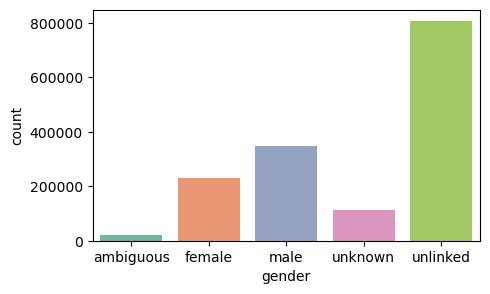

In [9]:
# plot gender distribution
plt.figure(figsize=(5, 3))
sns.countplot(x=genders, hue=genders, palette="Set2", dodge=False)

In [10]:
# merge gender data with ratings
genders.index.name = 'item'
merged_data = ratings.join(genders, on='item', how='left')
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 104007721 entries, 2007-01-02 21:26:24 to 2017-10-31 23:57:52
Data columns (total 4 columns):
 #   Column  Dtype   
---  ------  -----   
 0   user    int32   
 1   item    int32   
 2   rating  float32 
 3   gender  category
dtypes: category(1), float32(1), int32(2)
memory usage: 2.0 GB


In [11]:
merged_data.fillna({'gender':'unlinked'}, inplace=True)

# User Stats (user activity level)

In [12]:
# calculate when a user first appeared, and when they were last active, and how much they were active
users = ratings.reset_index().groupby('user')['timestamp'].agg(['min','max','count'])
users.head()

,min,max,count
user,,,
1,2007-01-09 17:04:00,2017-10-19 18:54:56,446
2,2012-06-05 01:46:40,2016-04-27 18:42:08,99
3,2008-03-17 22:24:00,2016-01-27 01:38:08,190
4,2012-06-05 02:40:00,2017-04-20 03:20:32,41
5,2012-06-05 01:55:12,2017-10-23 03:09:52,176


<Axes: xlabel='bridge', ylabel='count'>

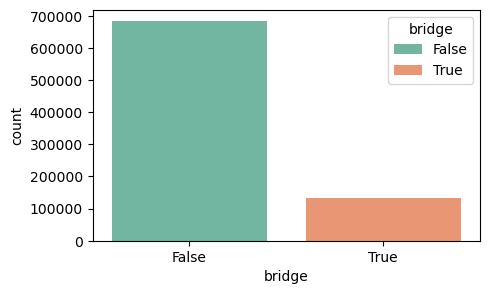

In [13]:
# calculate and plot what users were active both before and after the recommender was added
users['act_before'] = users['min'] <= date_rec_added - pd.to_timedelta('30D') 
users['act_after'] = users['max'] >= date_rec_added + pd.to_timedelta('30D')
users['bridge'] = users['act_before'] & users['act_after']

plt.figure(figsize=(5, 3))
sns.countplot(x=users['bridge'], hue=users['bridge'], palette="Set2", dodge=False)

In [14]:
# filtering ratings data (merged with gender) for active users
active_users = users[users['bridge']]
ratings_active_users = merged_data.join(active_users, on='user', how='inner')
ratings_active_users.head()

,user,item,rating,gender,min,max,count,act_before,act_after,bridge
timestamp,,,,,,,,,,
2007-01-02 21:26:24,223312,401024288,2.0,male,2007-01-02 21:26:24,2017-10-16 14:15:28,491,True,True,True
2007-01-02 21:28:32,223312,400888905,4.0,male,2007-01-02 21:26:24,2017-10-16 14:15:28,491,True,True,True
2007-01-02 21:28:32,223312,401320616,5.0,male,2007-01-02 21:26:24,2017-10-16 14:15:28,491,True,True,True
2007-01-02 21:30:40,223312,401308950,4.0,male,2007-01-02 21:26:24,2017-10-16 14:15:28,491,True,True,True
2007-01-02 21:30:40,223312,400814440,4.0,male,2007-01-02 21:26:24,2017-10-16 14:15:28,491,True,True,True


In [15]:
ratings_active_users.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 33255590 entries, 2007-01-02 21:26:24 to 2017-10-31 23:57:52
Data columns (total 10 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user        int32         
 1   item        int32         
 2   rating      float32       
 3   gender      category      
 4   min         datetime64[ns]
 5   max         datetime64[ns]
 6   count       int64         
 7   act_before  bool          
 8   act_after   bool          
 9   bridge      bool          
dtypes: bool(3), category(1), datetime64[ns](2), float32(1), int32(2), int64(1)
memory usage: 1.5 GB


# Item Stats

In [16]:
# caclulate item statistics
items_used = (ratings.reset_index().groupby('item').agg(min=('timestamp', 'min'),
        max=('timestamp', 'max'), count=('timestamp', 'count'),
        total_rating=('rating', 'sum') ))
items_used.head()

,min,max,count,total_rating
item,,,,
400000040,2007-07-26 16:21:20,2017-06-15 11:18:24,78,295.0
400000062,2007-07-21 18:42:08,2017-10-28 00:55:28,226,761.0
400000081,2007-05-13 01:16:48,2017-10-03 12:18:08,37,132.0
400000084,2007-06-11 05:28:32,2017-10-17 18:48:32,227,896.0
400000087,2007-05-24 02:52:48,2017-10-31 06:19:44,1880,7676.0


In [17]:
# calculate gini index for item consumption
gini(items_used['count'])

np.float64(0.9133399016506585)

Text(0, 0.5, 'Gini Inpdex')

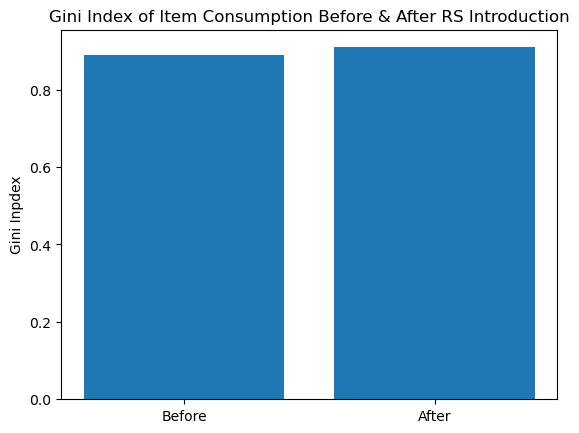

In [18]:
# gini index for item consumption before and after RS inroduction
before_data = (ratings[ratings.index < date_rec_added].reset_index().groupby('item').agg(count=('timestamp', 'count'),
        total_rating=('rating', 'sum') ))
after_data = (ratings[ratings.index >= date_rec_added].reset_index().groupby('item').agg(count=('timestamp', 'count'),
        total_rating=('rating', 'sum') ))

plt.bar(['Before', 'After'], [gini(before_data['count']), gini(after_data['count'])])
plt.title('Gini Index of Item Consumption Before & After RS Introduction')
plt.ylabel('Gini Inpdex')

# Growth Over Time

In [19]:
# analyze rating growth over time (total & gender-based)
gr_monthly_count = merged_data.resample('1ME').apply(lambda df: df.groupby('gender', observed=False)['item'].count())
gr_months = pd.DataFrame({
    'total': gr_monthly_count.sum(axis=1),
    'known': gr_monthly_count['male'] + gr_monthly_count['female']
        
})

gr_months['propFemale'] = gr_monthly_count['female']/gr_months['known']
gr_months['fMonthlyDiff'] = gr_months['propFemale'].diff()
gr_months['propKnown'] = gr_months['known']/gr_months['total']
gr_months['afterRec'] = (gr_months.index >= date_rec_added).astype('i1')
gr_months.head()

,total,known,propFemale,fMonthlyDiff,propKnown,afterRec
timestamp,,,,,,
2007-01-31,191,155,0.400000,NaN,0.811518,0
2007-02-28,5038,3556,0.253656,-0.146344,0.705836,0
2007-03-31,19592,13963,0.326291,0.072635,0.712689,0
2007-04-30,24402,18048,0.334275,0.007984,0.739612,0
2007-05-31,39537,29445,0.334420,0.000145,0.744745,0


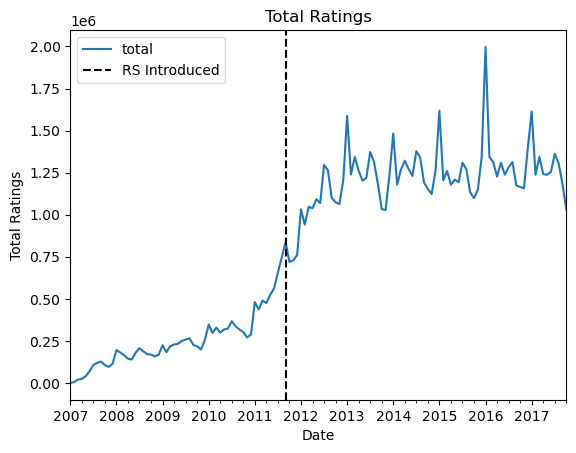

In [20]:
#plot ratings growth over time
gr_months.total.plot()

plt.axvline(date_rec_added, color='black', linestyle='--', label='RS Introduced')

plt.xlabel('Date')  
plt.ylabel('Total Ratings') 
plt.title('Total Ratings')
plt.legend()

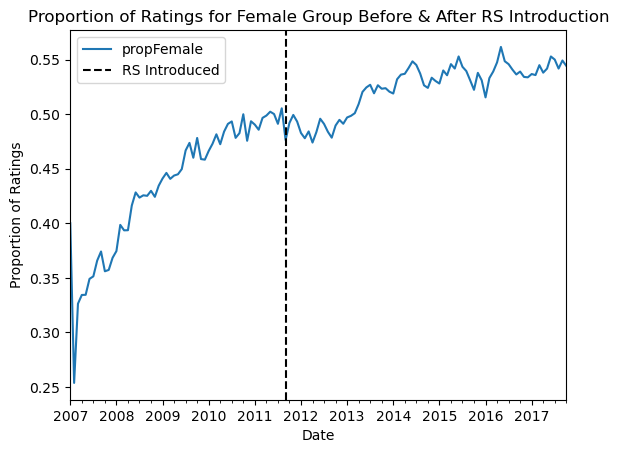

In [21]:
# plot ratings growth for female group over time
gr_months.propFemale.plot()

plt.axvline(date_rec_added, color='black', linestyle='--', label='RS Introduced')

plt.xlabel('Date')  
plt.ylabel('Proportion of Ratings') 
plt.title('Proportion of Ratings for Female Group Before & After RS Introduction')
plt.legend()

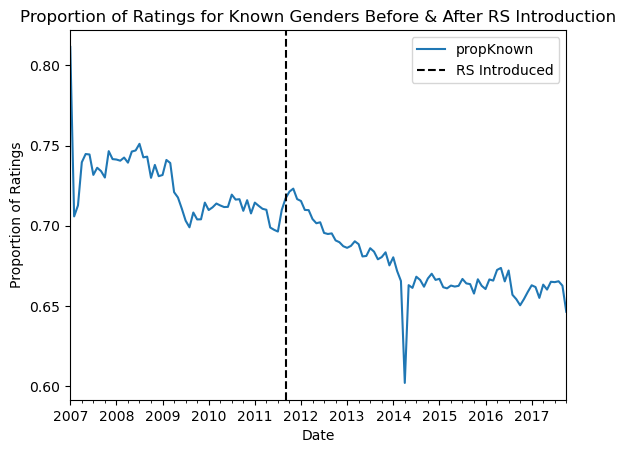

In [22]:
# plot ratings growth for total of known gender groups over time
gr_months.propKnown.plot()

plt.axvline(date_rec_added, color='black', linestyle='--', label='RS Introduced')

plt.xlabel('Date')  
plt.ylabel('Proportion of Ratings') 
plt.title('Proportion of Ratings for Known Genders Before & After RS Introduction')
plt.legend()

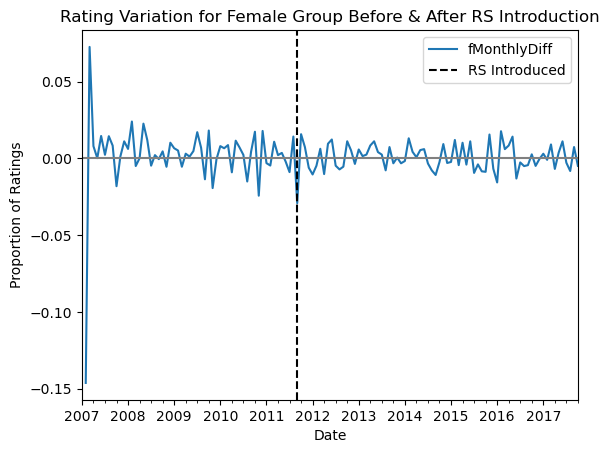

In [23]:
# plot rating variation for female group over time
gr_months.fMonthlyDiff.plot()

plt.axvline(date_rec_added, color='black', linestyle='--', label='RS Introduced')
plt.axhline(0, color='grey')

plt.xlabel('Date')  
plt.ylabel('Proportion of Ratings') 
plt.title('Rating Variation for Female Group Before & After RS Introduction')
plt.legend()

# Arima Analysis

In [24]:
ratings_arima = smt.ARIMA(gr_months.propFemale, order=(0,1,1), exog=gr_months['afterRec']).fit()
ratings_arima.summary()

/storage/sv849/goodreads-time/.pixi/envs/default/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             propFemale   No. Observations:                  130
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 356.853
Date:                Tue, 17 Dec 2024   AIC                           -707.706
Time:                        12:06:59   BIC                           -699.126
Sample:                    01-31-2007   HQIC                          -704.220
                         - 10-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
afterRec      -0.0153      0.021     -0.739      0.460      -0.056       0.025
ma.L1         -0.5324      0.089     -5.968      0.000      -0.707      -0.358
sigma2         0.0002   1.78e-05     12.958      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.80   Jarque-Bera (JB):             11858.64
Prob(Q):                              0.37   Prob(JB):                         0.00
Heteroskedasticity (H):               0.13   Skew:                            -5.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        48.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

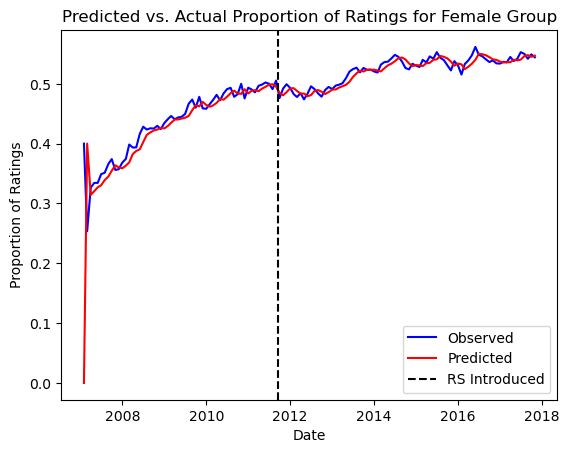

In [25]:
# plot arima model forecast
in_sample_preds = ratings_arima.predict(start=0, end=len(gr_months)-1, exog=gr_months['afterRec'])

# Plot the observed vs predicted ratings
plt.plot(gr_months.index, gr_months['propFemale'], label='Observed', color='blue')
plt.plot(gr_months.index, in_sample_preds, label='Predicted', color='red')
plt.axvline(date_rec_added, color='black', linestyle='--', label='RS Introduced')
plt.xlabel('Date')  
plt.ylabel('Proportion of Ratings')
plt.title('Predicted vs. Actual Proportion of Ratings for Female Group')
plt.legend()



# Active User Stats and Trends

In [26]:
# analyze rating growth over time (total & gender-based) for active users
active_monthly_count = ratings_active_users.resample('1ME').apply(lambda df: df.groupby('gender', observed=False)['item'].count())
active_months = pd.DataFrame({
    'total': active_monthly_count.sum(axis=1),
    'known': active_monthly_count['male'] + active_monthly_count['female']
        
})

active_months['propFemale'] = active_monthly_count['female']/active_months['known']
active_months['fMonthlyDiff'] = active_months['propFemale'].diff()
active_months['propKnown'] = active_months['known']/active_months['total']
active_months['afterRec'] = (active_months.index >= date_rec_added).astype('i1')
active_months.head()

,total,known,propFemale,fMonthlyDiff,propKnown,afterRec
timestamp,,,,,,
2007-01-31,149,122,0.245902,NaN,0.818792,0
2007-02-28,4995,3532,0.253964,0.008062,0.707107,0
2007-03-31,19512,13905,0.326286,0.072322,0.712638,0
2007-04-30,24302,17977,0.334817,0.008531,0.739733,0
2007-05-31,39222,29210,0.334474,-0.000342,0.744735,0


In [27]:
#percentage of ratings by active user after RS introduction
active_months['afterRec'].mean()

np.float64(0.5692307692307692)

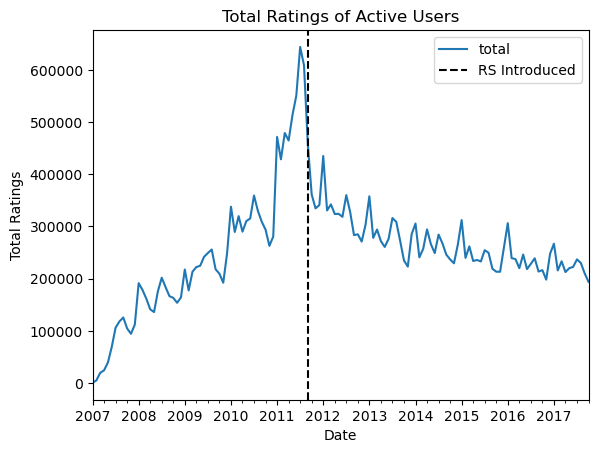

In [28]:
#plot ratings growth of active users over time
active_months.total.plot()

plt.axvline(date_rec_added, color='black', linestyle='--', label='RS Introduced')

plt.xlabel('Date')  
plt.ylabel('Total Ratings') 
plt.title('Total Ratings of Active Users')
plt.legend()

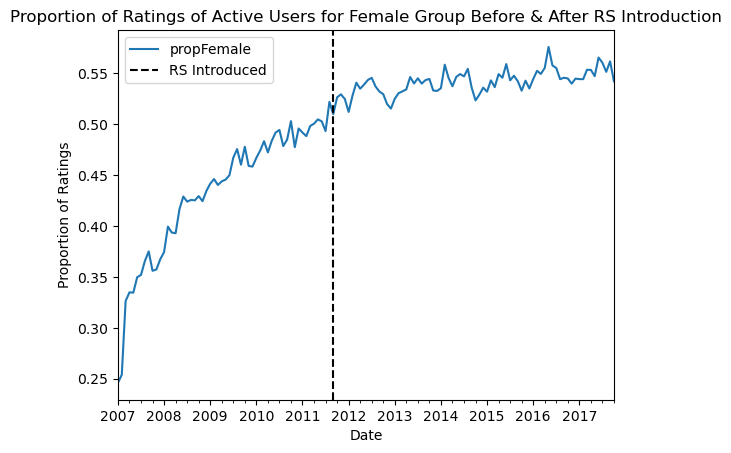

In [29]:
# plot ratings growth of active users for female group over time
active_months.propFemale.plot()

plt.axvline(date_rec_added, color='black', linestyle='--', label='RS Introduced')

plt.xlabel('Date')  
plt.ylabel('Proportion of Ratings') 
plt.title('Proportion of Ratings of Active Users for Female Group Before & After RS Introduction')
plt.legend()

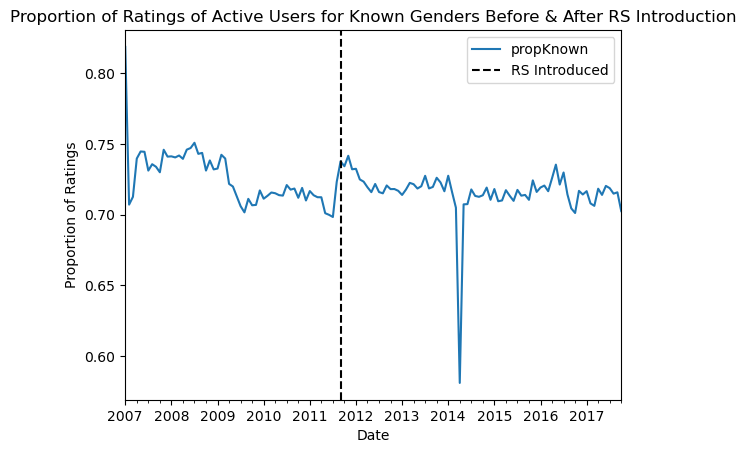

In [30]:
# plot ratings growth of active users for total of known gender groups over time
active_months.propKnown.plot()

plt.axvline(date_rec_added, color='black', linestyle='--', label='RS Introduced')

plt.xlabel('Date')  
plt.ylabel('Proportion of Ratings') 
plt.title('Proportion of Ratings of Active Users for Known Genders Before & After RS Introduction')
plt.legend()

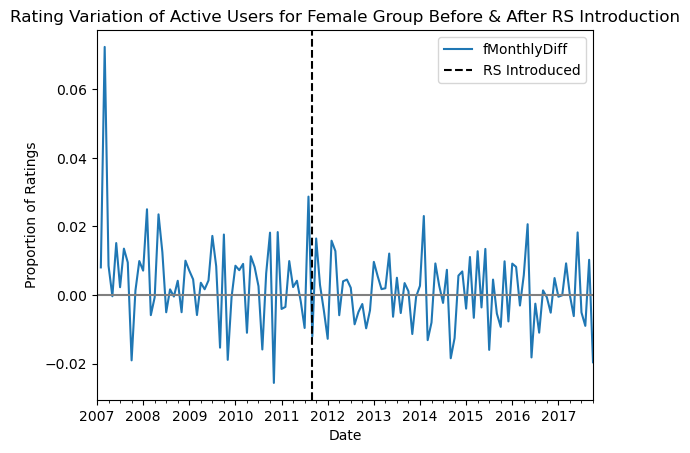

In [31]:
# plot rating variation of active users for female group over time
active_months.fMonthlyDiff.plot()

plt.axvline(date_rec_added, color='black', linestyle='--', label='RS Introduced')
plt.axhline(0, color='grey')

plt.xlabel('Date')  
plt.ylabel('Proportion of Ratings') 
plt.title('Rating Variation of Active Users for Female Group Before & After RS Introduction')
plt.legend()

In [32]:
active_months.groupby('afterRec').fMonthlyDiff.mean()

afterRec
0    0.005015
1    0.000272
Name: fMonthlyDiff, dtype: float64

In [33]:
ratings_active_arima = smt.ARIMA(active_months.propFemale, order=(1,1,1)).fit()
ratings_active_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             propFemale   No. Observations:                  130
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 386.578
Date:                Tue, 17 Dec 2024   AIC                           -767.157
Time:                        12:07:02   BIC                           -758.577
Sample:                    01-31-2007   HQIC                          -763.671
                         - 10-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0300      0.980     -0.031      0.976      -1.951       1.891
ma.L1         -0.0994      0.979     -0.102      0.919      -2.018       1.819
sigma2         0.0001   8.11e-06     18.005      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):               439.75
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               0.36   Skew:                             1.58
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

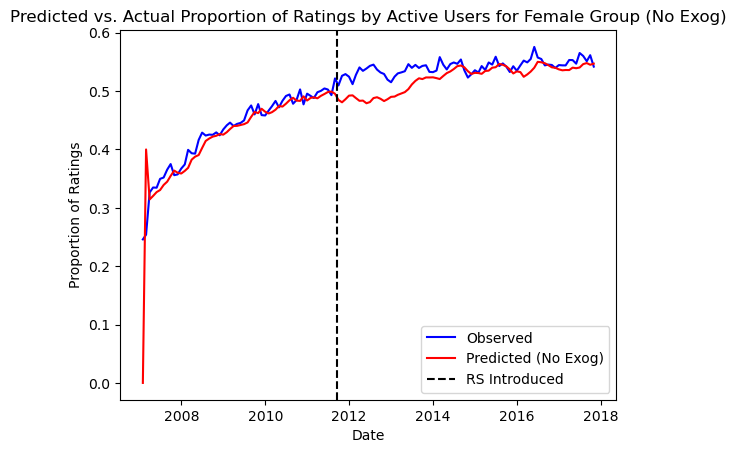

In [34]:
# plot arima model forecast for active users (No Exog)
active_sample_preds = ratings_arima.predict(start=0, end=len(active_months)-1)

# Plot the observed vs predicted ratings
plt.plot(active_months.index, active_months['propFemale'], label='Observed', color='blue')
plt.plot(active_months.index, active_sample_preds, label='Predicted (No Exog)', color='red')
plt.axvline(date_rec_added, color='black', linestyle='--', label='RS Introduced')
plt.xlabel('Date')  
plt.ylabel('Proportion of Ratings')
plt.title('Predicted vs. Actual Proportion of Ratings by Active Users for Female Group (No Exog)')
plt.legend()

In [35]:
# training with exogenous variable
ratings_active_arima = smt.ARIMA(active_months.propFemale, order=(0,1,1), exog=active_months['afterRec']).fit()
ratings_active_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             propFemale   No. Observations:                  130
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 386.729
Date:                Tue, 17 Dec 2024   AIC                           -767.458
Time:                        12:07:03   BIC                           -758.879
Sample:                    01-31-2007   HQIC                          -763.972
                         - 10-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
afterRec      -0.0071      0.056     -0.127      0.899      -0.117       0.103
ma.L1         -0.1116      0.084     -1.335      0.182      -0.275       0.052
sigma2         0.0001   8.06e-06     18.071      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.39   Jarque-Bera (JB):               438.59
Prob(Q):                              0.53   Prob(JB):                         0.00
Heteroskedasticity (H):               0.36   Skew:                             1.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

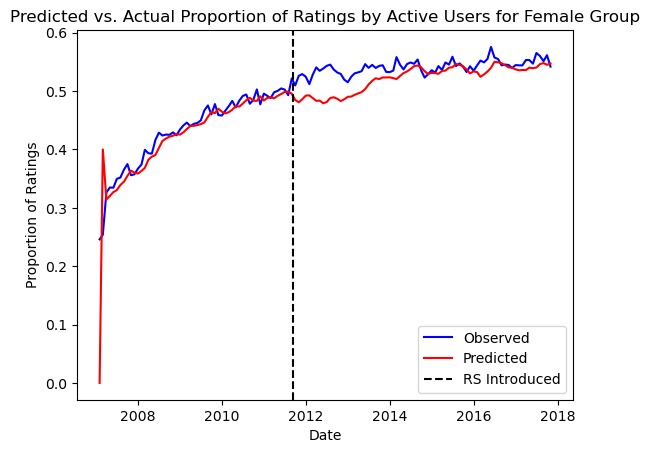

In [36]:
# plot arima model forecast for active users
active_sample_preds = ratings_arima.predict(start=0, end=len(active_months)-1, exog=active_months['afterRec'])

# Plot the observed vs predicted ratings
plt.plot(active_months.index, active_months['propFemale'], label='Observed', color='blue')
plt.plot(active_months.index, active_sample_preds, label='Predicted', color='red')
plt.axvline(date_rec_added, color='black', linestyle='--', label='RS Introduced')
plt.xlabel('Date')  
plt.ylabel('Proportion of Ratings')
plt.title('Predicted vs. Actual Proportion of Ratings by Active Users for Female Group')
plt.legend()

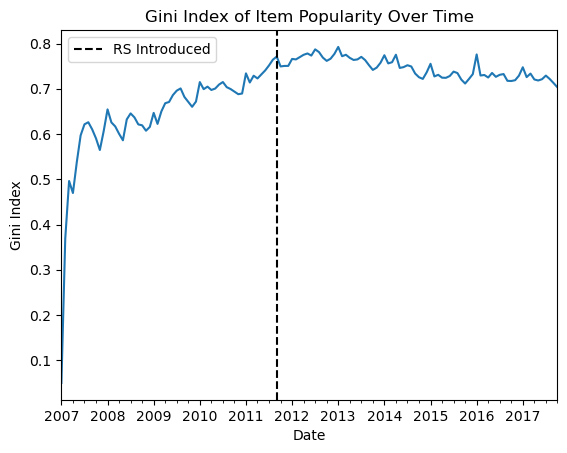

In [37]:
# calculate and plot gini over time for items' popularity
ratings_gini = merged_data.resample('1ME').apply(lambda df: gini(df.groupby('item', observed=False)['user'].count()))

ratings_gini.plot()
plt.axvline(date_rec_added, color='black', linestyle='--', label='RS Introduced')
plt.xlabel('Date')  
plt.ylabel('Gini Index') 
plt.title('Gini Index of Item Popularity Over Time')
plt.legend()

# Action Data and Popularity Bias

In [38]:
# load work-actions data
actions = pd.read_parquet(work_actions, columns=['user', 'item', 'first_time','nactions'])
actions['first_time'] = pd.to_datetime(actions['first_time'], unit='s')
actions.head()

,user,item,first_time,nactions
0,1,440787528,2017-05-22 15:17:20,1
1,1,400033362,2017-05-26 19:03:28,1
2,1,400795790,2013-05-01 19:54:40,1
3,1,412946965,2017-03-22 18:46:24,1
4,1,403078186,2008-04-23 17:16:48,1


In [39]:
before_actions = actions[actions['first_time'] < date_rec_added]
after_actions = actions[actions['first_time'] >= date_rec_added]
before_actions.head()

,user,item,first_time,nactions
4,1,403078186,2008-04-23 17:16:48,1
5,1,400882196,2009-06-05 19:29:04,1
6,1,402603195,2007-01-18 01:14:40,1
75,31,403258721,2008-09-24 00:57:36,1
125,71,400064868,2008-10-23 19:20:32,1


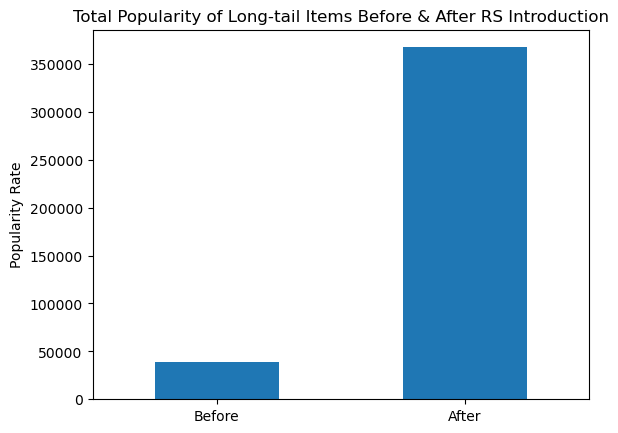

In [40]:
# define long-tail items as 20% of items with least consumption relative to total item consumption
items_pop = actions.groupby('item')['user'].nunique()
items_pop /= items_pop.sum()
items_pop.head()
sorted_pop = items_pop.sort_values()
longtail_prop = int(len(sorted_pop)*0.2)
longtail_items = sorted_pop.iloc[:longtail_prop]

# extract long-tail items in before and after data
before_tail = before_actions[before_actions['item'].isin(longtail_items.index)]
after_tail = after_actions[after_actions['item'].isin(longtail_items.index)]

#calculate popularity of long-tail items before and after RS
before_p = before_tail.groupby('item')['user'].nunique()/items_pop.sum()
after_p = after_tail.groupby('item')['user'].nunique()/items_pop.sum()

merged_p = pd.DataFrame({'Before': before_p, 'After': after_p})
merged_p = merged_p.fillna(0)

column_sums = merged_p.sum()

column_sums.plot(kind='bar') 
plt.title('Total Popularity of Long-tail Items Before & After RS Introduction')
plt.ylabel('Popularity Rate')
plt.xticks(rotation=0)
plt.show()

In [41]:
end_time = time.time()
elapsed_time = (end_time - start_time) / 60
print(f"Time taken: {elapsed_time:.2f} minutes")

Time taken: 3.83 minutes
